In [1]:
!pip install pyspark

# IMPORTING NECESSARY LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, regexp_extract
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import DataFrame
from pyspark.ml.feature import MinMaxScaler

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# STARTING PYSPARK SESSION AND LOADING DATASET - HDFS

In [3]:
spark = SparkSession.builder.appName("lending-club").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/10 19:22:41 WARN Utils: Your hostname, DESKTOP-I4C3SAV, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/10/10 19:22:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/10 19:22:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/10 19:22:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
def one_hot_encode_column(df, input_col):
    indexer = StringIndexer(inputCol=input_col, outputCol=input_col + '_indexed')
    indexed_df = indexer.fit(df).transform(df)

    encoder = OneHotEncoder(inputCol=input_col + '_indexed', outputCol=input_col + '_encoded')
    encoded_df = encoder.fit(indexed_df).transform(indexed_df)

    encoded_df = encoded_df.drop(input_col, input_col + '_indexed')

    return encoded_df

def scale_features(input_df: DataFrame, input_col: str, output_col: str) -> DataFrame:
    """
    Scale the specified feature column using Min-Max Scaling.

    Args:
        input_df (DataFrame): The input DataFrame.
        input_col (str): The name of the feature column to scale.
        output_col (str): The name of the output scaled feature column.

    Returns:
        DataFrame: The DataFrame with the scaled feature column.
    """
    scaler = MinMaxScaler(inputCol=input_col, outputCol=output_col)
    scaler_model = scaler.fit(input_df)
    scaled_df = scaler_model.transform(input_df)
    return scaled_df

def evaluate_model(model, model_name, train_data, validation_data, test_data):
    model = model.fit(train_data)

    predictions_train = model.transform(train_data)
    predictions_validation = model.transform(validation_data)
    predictions_test = model.transform(test_data)

    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
    f1_evaluator = MulticlassClassificationEvaluator(metricName="weightedFMeasure", labelCol="target")

    accuracy_train = evaluator_accuracy.evaluate(predictions_train)
    f1_score_train = f1_evaluator.evaluate(predictions_train)

    accuracy_validation = evaluator_accuracy.evaluate(predictions_validation)
    f1_score_validation = f1_evaluator.evaluate(predictions_validation)

    accuracy_test = evaluator_accuracy.evaluate(predictions_test)
    f1_score_test = f1_evaluator.evaluate(predictions_test)

    results_df = pd.DataFrame({
    "Model": [model_name],
    "Accuracy (Train)": [round(accuracy_train, 3)],
    "F1 Score (Train)": [round(f1_score_train, 3)],
    "Accuracy (Validation)": [round(accuracy_validation, 3)],
    "F1 Score (Validation)": [round(f1_score_validation, 3)],
    "Accuracy (Test)": [round(accuracy_test, 3)],
    "F1 Score (Test)": [round(f1_score_test, 3)],
    })

    return results_df

In [5]:
import os
from pyspark.sql import SparkSession

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["HADOOP_HOME"] = "/usr/local/hadoop"
os.environ["PATH"] = os.environ["PATH"] + ":/usr/local/hadoop/bin"

spark = SparkSession.builder \
    .appName("Loan-Outcome-Analysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

25/10/10 19:23:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [6]:
selected_columns = [
    "id", "purpose", "term", "verification_status", "acc_now_delinq", 
    "addr_state", "annual_inc", "application_type", "dti", "grade", 
    "home_ownership", "initial_list_status", "installment", "int_rate", 
    "loan_amnt", "loan_status", 'tax_liens', 'delinq_amnt', 'policy_code', 
    'last_fico_range_high', 'last_fico_range_low', 'recoveries', 
    'collection_recovery_fee'
]

df = spark.read.option("header", "true").option("inferSchema", "false") \
    .csv("hdfs://localhost:9000/user/hduser/input/accepted_2007_to_2018Q4.csv") \
    .select(selected_columns) 

df.limit(5).toPandas()

id             purpose        term verification_status  \
0  68407277  debt_consolidation   36 months        Not Verified   
1  68355089      small_business   36 months        Not Verified   
2  68341763    home_improvement   60 months        Not Verified   
3  66310712  debt_consolidation   60 months     Source Verified   
4  68476807      major_purchase   60 months     Source Verified   

  acc_now_delinq addr_state annual_inc application_type    dti grade  ...  \
0            0.0         PA    55000.0       Individual   5.91     C  ...   
1            0.0         SD    65000.0       Individual  16.06     C  ...   
2            0.0         IL    63000.0        Joint App  10.78     B  ...   
3            0.0         NJ   110000.0       Individual  17.06     C  ...   
4            0.0         PA   104433.0       Individual  25.37     F  ...   

  int_rate loan_amnt loan_status tax_liens delinq_amnt policy_code  \
0    13.99    3600.0  Fully Paid       0.0         0.0         1.0   
1    11.99   24700.0  Fully Paid       0.0         0.0         1.0   
2    10.78   20000.0  Fully Paid       0.0         0.0         1.0   
3    14.85   35000.0     Current       0.0         0.0         1.0   
4    22.45   10400.0  Fully Paid       0.0         0.0         1.0   

  last_fico_range_high last_fico_range_low recoveries collection_recovery_fee  
0                564.0               560.0        0.0                     0.0  
1                699.0               695.0        0.0                     0.0  
2                704.0               700.0        0.0                     0.0  
3                679.0               675.0        0.0                     0.0  
4                704.0               700.0        0.0                     0.0  

[5 rows x 23 columns]

# ABOUT THE DATASET & DUPLICATE REMOVAL

In [7]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- term: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- acc_now_delinq: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- application_type: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- loan_amnt: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- tax_liens: string (nullable = true)
 |-- delinq_amnt: string (nullable = true)
 |-- policy_code: string (nullable = true)
 |-- last_fico_range_high: string (nullable = true)
 |-- last_fico_range_low: string (nullable = true)
 |-- recoveries: string (nullable = true)
 |-- collection_recovery_fee: string (nullable = 

In [8]:
df.count()

2260701

In [62]:
# null_counts = df.agg(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
# null_counts.show()

In [9]:
# to fix the above error
numeric_cols = [f.name for f in df.schema.fields if f.dataType.simpleString() in ["double", "float", "int", "bigint", "decimal"]]
# Count nulls (all columns) + NaN (only numeric columns)
null_counts = df.agg(
    *[
        count(
            when(
                col(c).isNull() | 
                ((c in numeric_cols) & col(c).isNaN()), 
                c
            )
        ).alias(c)
        for c in df.columns
    ]
)

null_counts.show()

[Stage 5:====================================================>    (12 + 1) / 13]

+---+-------+----+-------------------+--------------+----------+----------+----------------+----+-----+--------------+-------------------+-----------+--------+---------+-----------+---------+-----------+-----------+--------------------+-------------------+----------+-----------------------+
| id|purpose|term|verification_status|acc_now_delinq|addr_state|annual_inc|application_type| dti|grade|home_ownership|initial_list_status|installment|int_rate|loan_amnt|loan_status|tax_liens|delinq_amnt|policy_code|last_fico_range_high|last_fico_range_low|recoveries|collection_recovery_fee|
+---+-------+----+-------------------+--------------+----------+----------+----------------+----+-----+--------------+-------------------+-----------+--------+---------+-----------+---------+-----------+-----------+--------------------+-------------------+----------+-----------------------+
|  0|     34|  33|                 33|           221|        34|        37|              88|1745|   33|            33|      

In [10]:
df = df.na.drop()

In [11]:
df.count()

2258596

# EDA

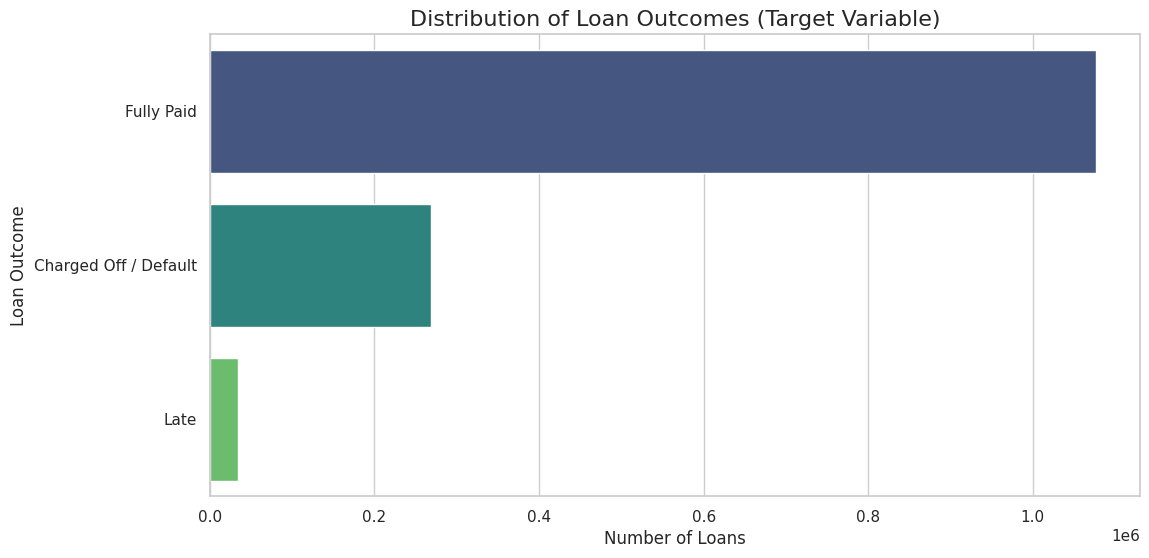

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
loan_status_counts = df.groupBy('target').count().toPandas()
target_map = {0: 'Fully Paid', 1: 'Late', 2: 'Charged Off / Default'}
loan_status_counts['outcome'] = loan_status_counts['target'].map(target_map)
loan_status_counts = loan_status_counts.sort_values('count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='outcome', data=loan_status_counts, palette='viridis')
plt.title('Distribution of Loan Outcomes (Target Variable)', fontsize=16)
plt.xlabel('Number of Loans', fontsize=12)
plt.ylabel('Loan Outcome', fontsize=12)
plt.show()

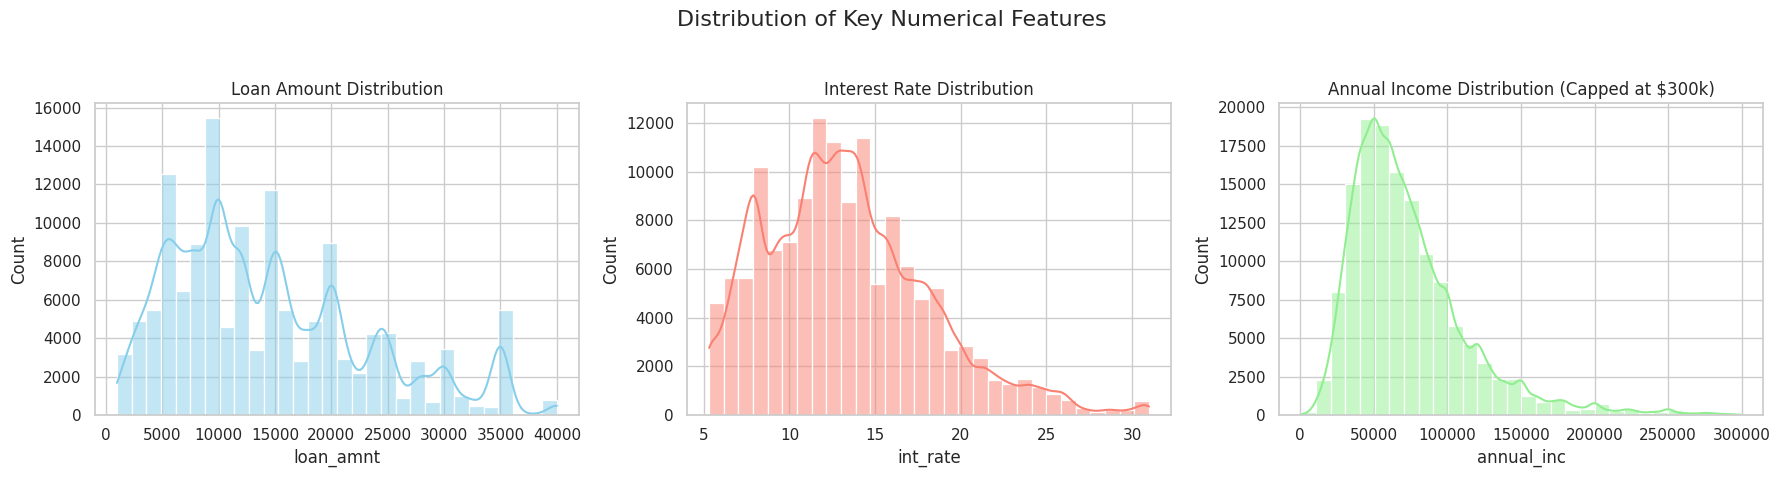

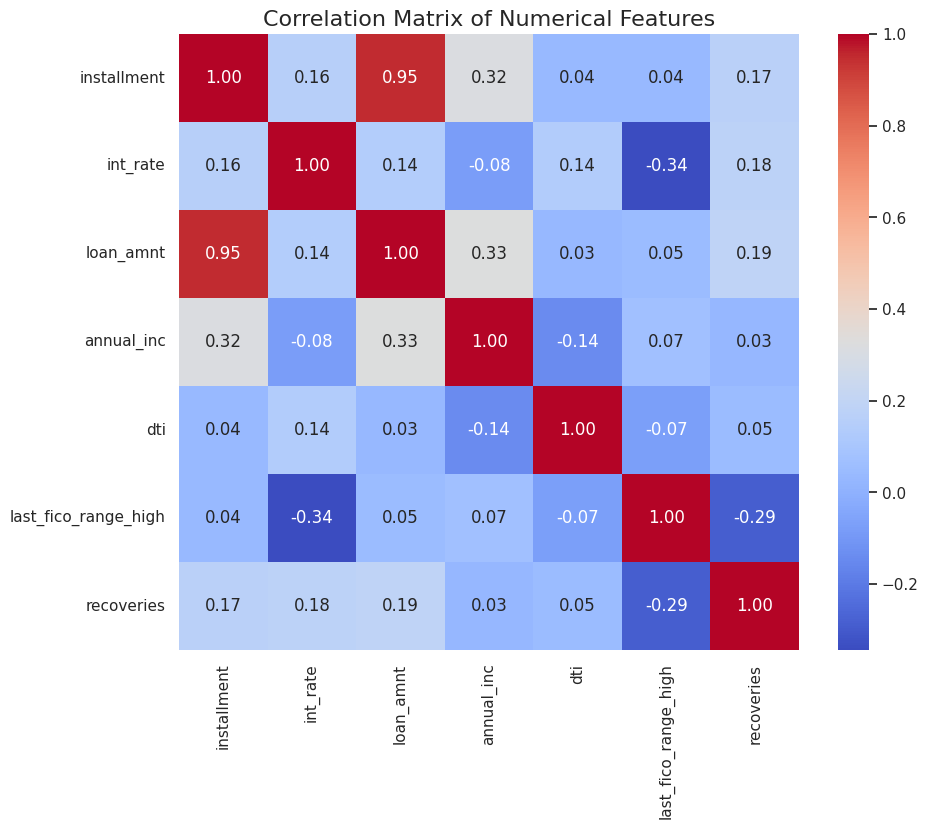

In [38]:
sample_df_pd = df.select('loan_amnt', 'int_rate', 'annual_inc').sample(False, 0.1, seed=42).toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Key Numerical Features', fontsize=16)

sns.histplot(sample_df_pd['loan_amnt'], bins=30, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Loan Amount Distribution')

sns.histplot(sample_df_pd['int_rate'], bins=30, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Interest Rate Distribution')

sns.histplot(sample_df_pd[sample_df_pd['annual_inc'] < 300000]['annual_inc'], bins=30, ax=axes[2], color='lightgreen', kde=True)
axes[2].set_title('Annual Income Distribution (Capped at $300k)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

numeric_cols_for_corr = [
    'installment', 'int_rate', 'loan_amnt', 'annual_inc', 'dti', 
    'last_fico_range_high', 'recoveries'
]
corr_sample_df = df.select(numeric_cols_for_corr).sample(False, 0.1, seed=42).toPandas()
corr_matrix = corr_sample_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

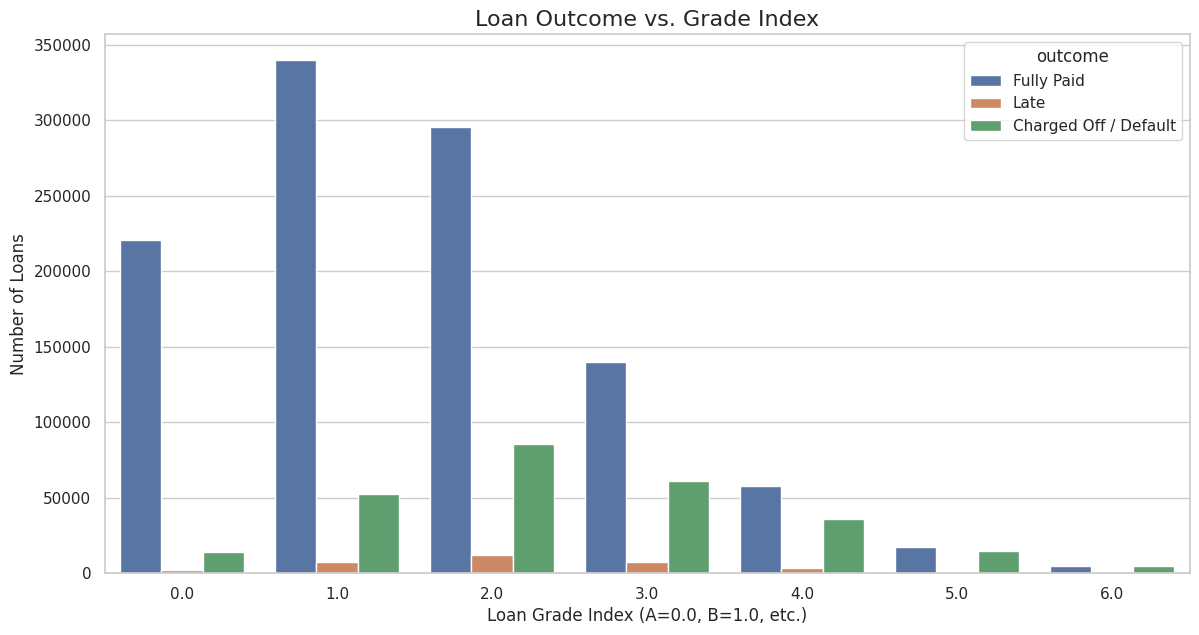

In [39]:
grade_status_df = df.groupBy('grade_index', 'target').count().toPandas()

target_map = {0: 'Fully Paid', 1: 'Late', 2: 'Charged Off / Default'}
grade_status_df['outcome'] = grade_status_df['target'].map(target_map)

plt.figure(figsize=(14, 7))
sns.barplot(x='grade_index', y='count', hue='outcome', data=grade_status_df)
plt.title('Loan Outcome vs. Grade Index', fontsize=16)
plt.xlabel('Loan Grade Index (A=0.0, B=1.0, etc.)', fontsize=12)
plt.ylabel('Number of Loans', fontsize=12)
plt.show()

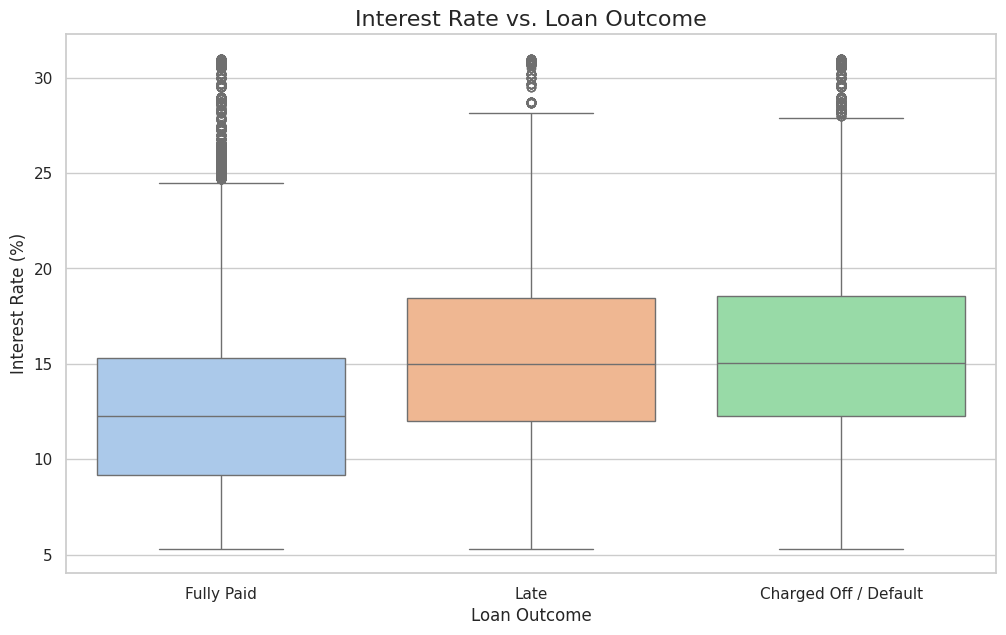

In [40]:
sample_pd = df.select('target', 'int_rate').sample(False, 0.1, seed=42).toPandas()

target_map = {0: 'Fully Paid', 1: 'Late', 2: 'Charged Off / Default'}
sample_pd['outcome'] = sample_pd['target'].map(target_map)

plt.figure(figsize=(12, 7))
sns.boxplot(x='outcome', y='int_rate', data=sample_pd, palette='pastel', 
            order=['Fully Paid', 'Late', 'Charged Off / Default']) # Set a logical order
plt.title('Interest Rate vs. Loan Outcome', fontsize=16)
plt.xlabel('Loan Outcome', fontsize=12)
plt.ylabel('Interest Rate (%)', fontsize=12)
plt.show()

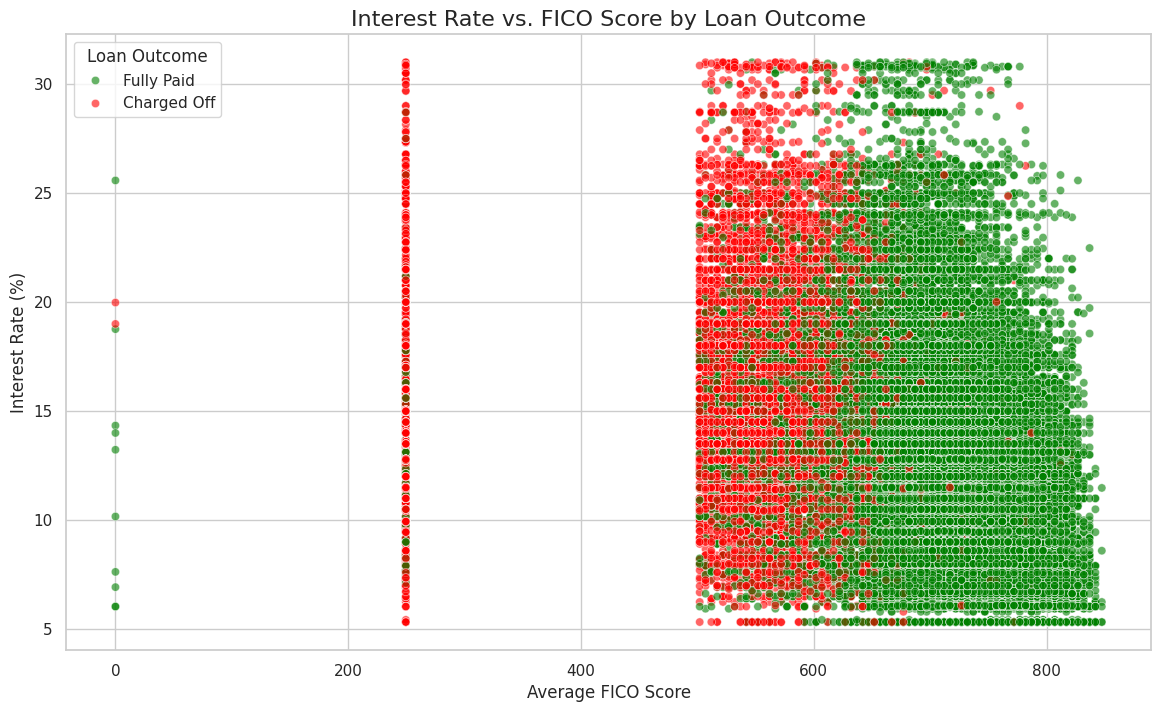

In [41]:
from pyspark.sql.functions import avg, col

df_fico = df.withColumn('fico_score', (col('last_fico_range_high') + col('last_fico_range_low')) / 2)

df_fico_filtered = df_fico.filter(col('target').isin([0, 2]))

fico_sample_pd = df_fico_filtered.sample(False, 0.05, seed=42).toPandas()

target_map = {0: 'Fully Paid', 2: 'Charged Off'}
fico_sample_pd['outcome'] = fico_sample_pd['target'].map(target_map)

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=fico_sample_pd, 
    x='fico_score', 
    y='int_rate', 
    hue='outcome',  # Corrected from 'loan_status' to 'outcome'
    palette={'Fully Paid': 'green', 'Charged Off': 'red'},
    alpha=0.6
)

plt.title('Interest Rate vs. FICO Score by Loan Outcome', fontsize=16)
plt.xlabel('Average FICO Score', fontsize=12)
plt.ylabel('Interest Rate (%)', fontsize=12)
plt.legend(title='Loan Outcome')
plt.show()

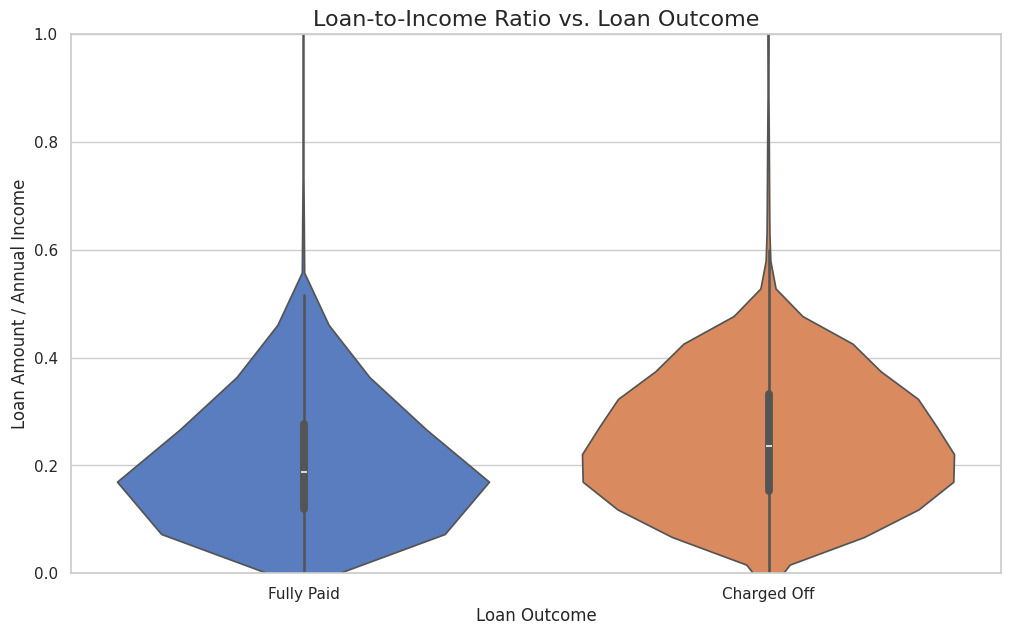

In [42]:
from pyspark.sql.functions import col

df_ratio = df.withColumn('loan_to_income_ratio', col('loan_amnt') / col('annual_inc'))

df_ratio_filtered = df_ratio.filter(
    col('target').isin([0, 2]) & (col('annual_inc') > 1000)
)

ratio_sample_pd = df_ratio_filtered.sample(False, 0.1, seed=42).toPandas()

target_map = {0: 'Fully Paid', 2: 'Charged Off'}
ratio_sample_pd['outcome'] = ratio_sample_pd['target'].map(target_map)

plt.figure(figsize=(12, 7))
sns.violinplot(
    data=ratio_sample_pd, 
    x='outcome', 
    y='loan_to_income_ratio',
    palette='muted'
)

plt.title('Loan-to-Income Ratio vs. Loan Outcome', fontsize=16)
plt.xlabel('Loan Outcome', fontsize=12)
plt.ylabel('Loan Amount / Annual Income', fontsize=12)
plt.ylim(0, 1.0) 
plt.show()

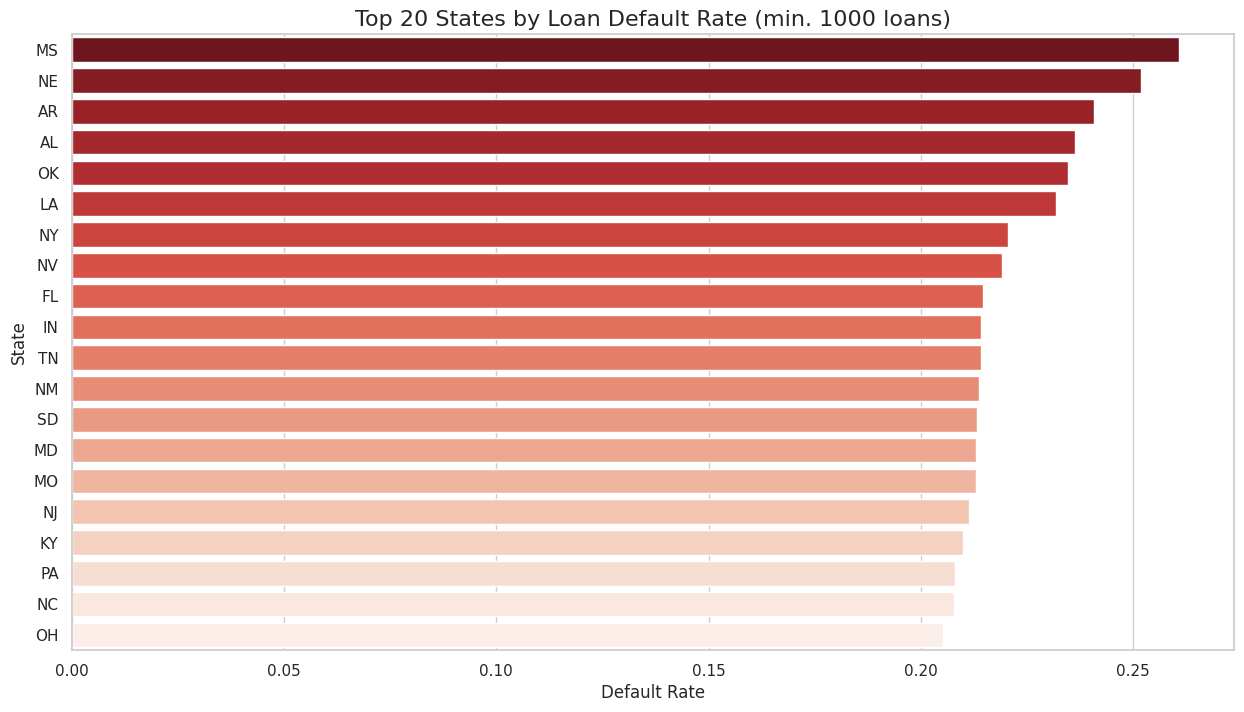

In [46]:
from pyspark.sql.functions import avg, count, when, col

df_for_state_analysis = spark.read.option("header", "true").option("inferSchema", "false") \
    .csv("hdfs://localhost:9000/user/hduser/input/accepted_2007_to_2018Q4.csv") \
    .select('addr_state', 'loan_status').na.drop()

df_state = df_for_state_analysis.filter(col('loan_status').isin(['Fully Paid', 'Charged Off'])) \
                                .withColumn('is_default', when(col('loan_status') == 'Charged Off', 1).otherwise(0))

state_default_rates = df_state.groupBy('addr_state') \
    .agg(
        avg('is_default').alias('default_rate'),
        count('*').alias('num_loans')
    ) \
    .orderBy('default_rate', ascending=False)

state_rates_pd = state_default_rates.filter(col('num_loans') > 1000).toPandas()

plt.figure(figsize=(15, 8))
sns.barplot(
    data=state_rates_pd.head(20),
    x='default_rate',
    y='addr_state',
    palette='Reds_r'
)

plt.title('Top 20 States by Loan Default Rate (min. 1000 loans)', fontsize=16)
plt.xlabel('Default Rate', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.show()

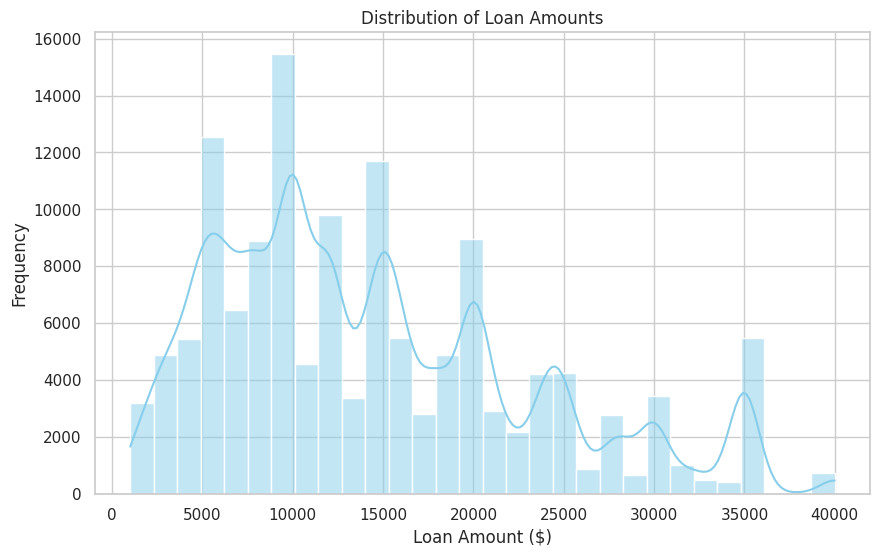

In [47]:
# Distribution of Loan Amounts
# Useful for lenders to understand typical loan sizes and for borrowers to see common loan amounts
import seaborn as sns
import matplotlib.pyplot as plt
df_pandas = df.select('loan_amnt').sample(False, 0.1, seed=42).toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(df_pandas['loan_amnt'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount ($)')
plt.ylabel('Frequency')
plt.show()

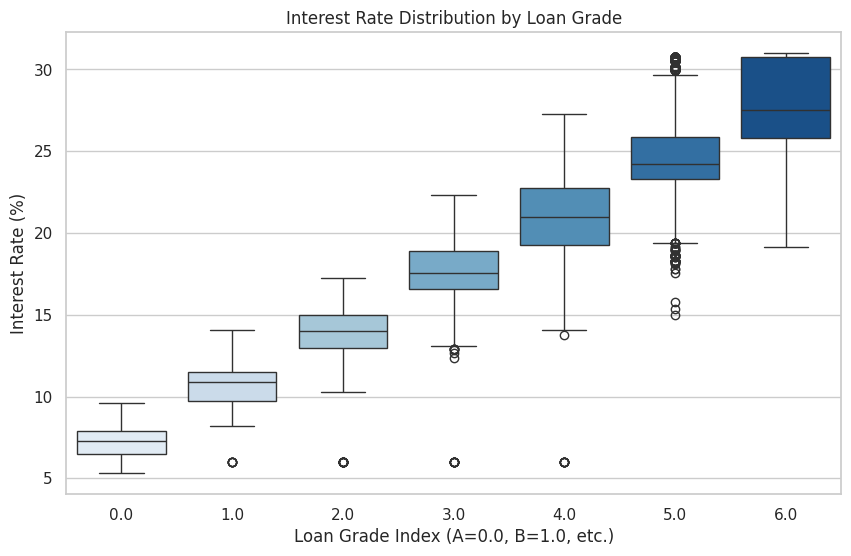

In [48]:
# Interest Rate by Loan Grade
# Helps lenders assess risk by grade and borrowers understand interest rate expectations
import seaborn as sns
import matplotlib.pyplot as plt

df_pandas = df.select('grade_index', 'int_rate').sample(False, 0.1, seed=42).toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(x='grade_index', y='int_rate', data=df_pandas, order=sorted(df_pandas['grade_index'].unique()), palette='Blues')
plt.title('Interest Rate Distribution by Loan Grade')
plt.xlabel('Loan Grade Index (A=0.0, B=1.0, etc.)')
plt.ylabel('Interest Rate (%)')
plt.show()

/home/hduser/pyspark-env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hduser/pyspark-env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 153 (\x99) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


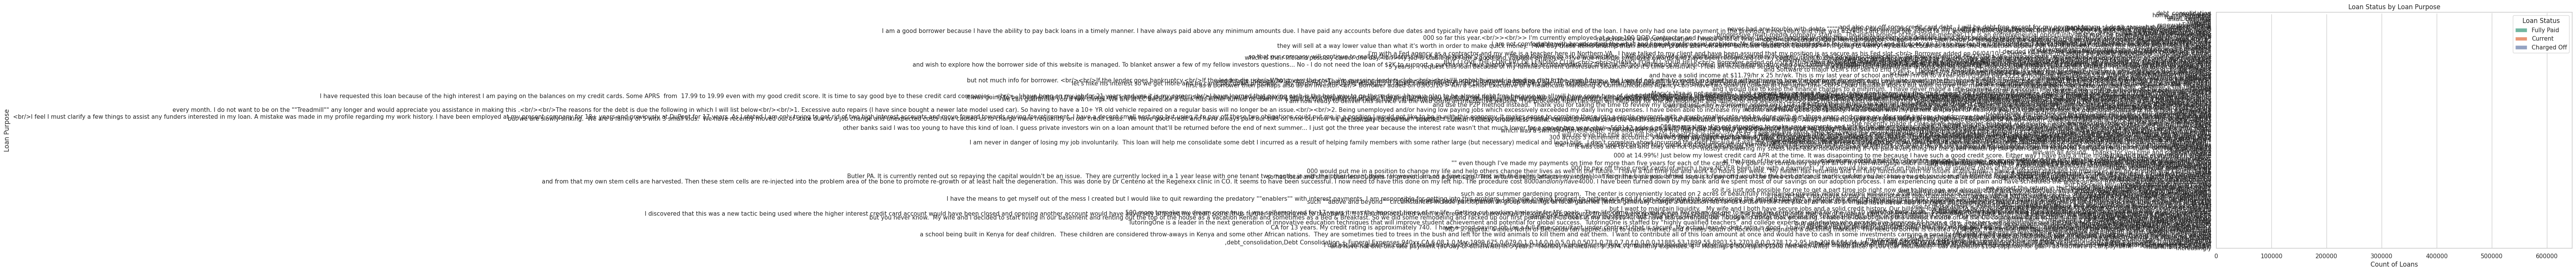

In [50]:
# Loan Status by Purpose
# Allows lenders to evaluate risk by loan purpose and borrowers to see approval trends
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

df_for_purpose_analysis = spark.read.option("header", "true").option("inferSchema", "false") \
    .csv("hdfs://localhost:9000/user/hduser/input/accepted_2007_to_2018Q4.csv") \
    .select('purpose', 'loan_status').na.drop()

df_filtered = df_for_purpose_analysis.filter(
    col('loan_status').isin(['Fully Paid', 'Charged Off', 'Current'])
)

df_pandas = df_filtered.toPandas()
plt.figure(figsize=(12, 8))
sns.countplot(y='purpose', hue='loan_status', data=df_pandas, palette='Set2',
              order=df_pandas['purpose'].value_counts().index)
plt.title('Loan Status by Loan Purpose')
plt.xlabel('Count of Loans')
plt.ylabel('Loan Purpose')
plt.legend(title='Loan Status')
plt.show()

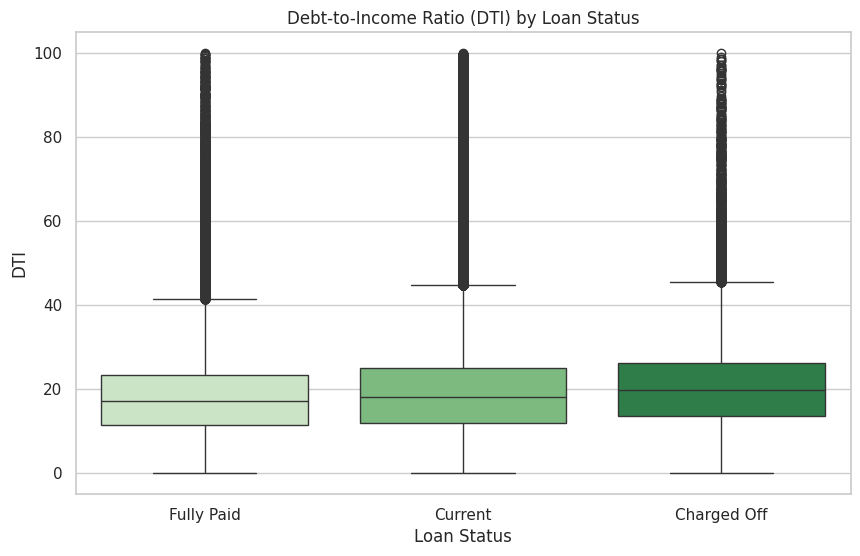

In [52]:
# DTI vs Loan Status
# Helps lenders identify risky DTI levels and borrowers understand DTI impact
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

df_for_dti_analysis = spark.read.option("header", "true") \
    .csv("hdfs://localhost:9000/user/hduser/input/accepted_2007_to_2018Q4.csv") \
    .select('loan_status', 'dti')

df_for_dti_analysis = df_for_dti_analysis.filter(col("dti").isNotNull()) \
                                         .filter(col("dti").rlike("^[0-9]*\\.?[0-9]+$"))

df_for_dti_analysis = df_for_dti_analysis.withColumn("dti", col("dti").cast("float"))

df_filtered = df_for_dti_analysis.filter(
    (col('loan_status').isin(['Fully Paid', 'Charged Off', 'Current'])) &
    (col('dti') < 100) 
)

df_pandas = df_filtered.toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='dti', data=df_pandas, palette='Greens', 
            order=['Fully Paid', 'Current', 'Charged Off']) 
plt.title('Debt-to-Income Ratio (DTI) by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('DTI')
plt.show()

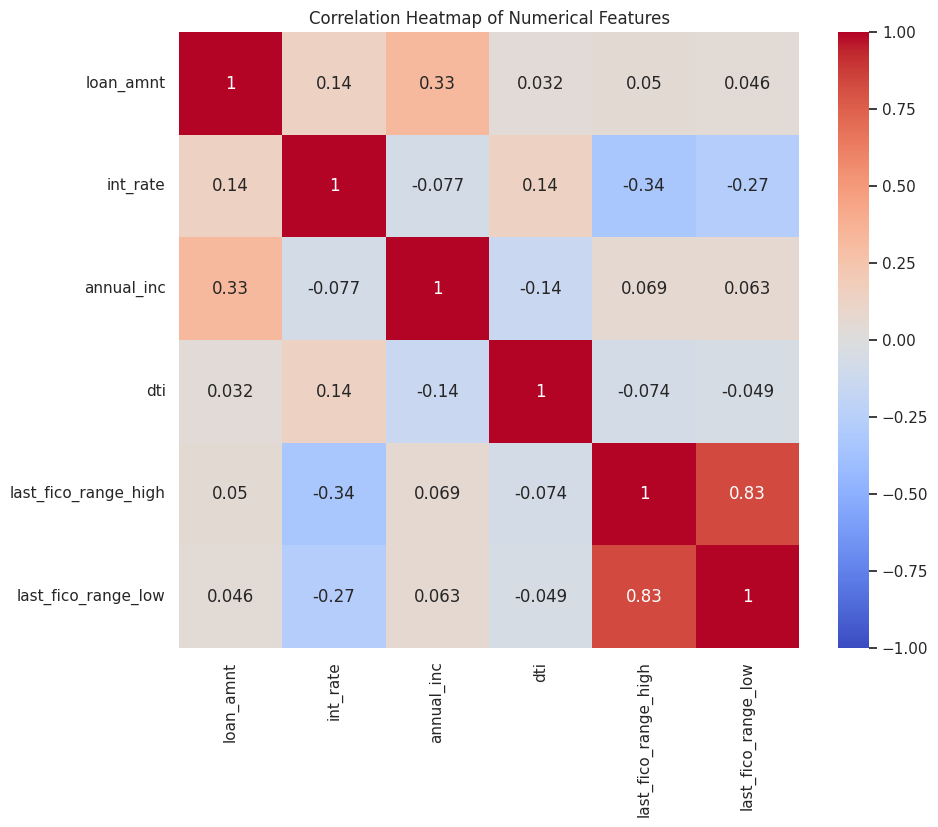

In [53]:
# Correlation Heatmap of Numerical Features
# Provides insights into relationships between features like income, DTI, and FICO scores
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'last_fico_range_high', 'last_fico_range_low']
df_pandas = df.select(numerical_cols).sample(False, 0.1, seed=42).toPandas()
corr_matrix = df_pandas[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

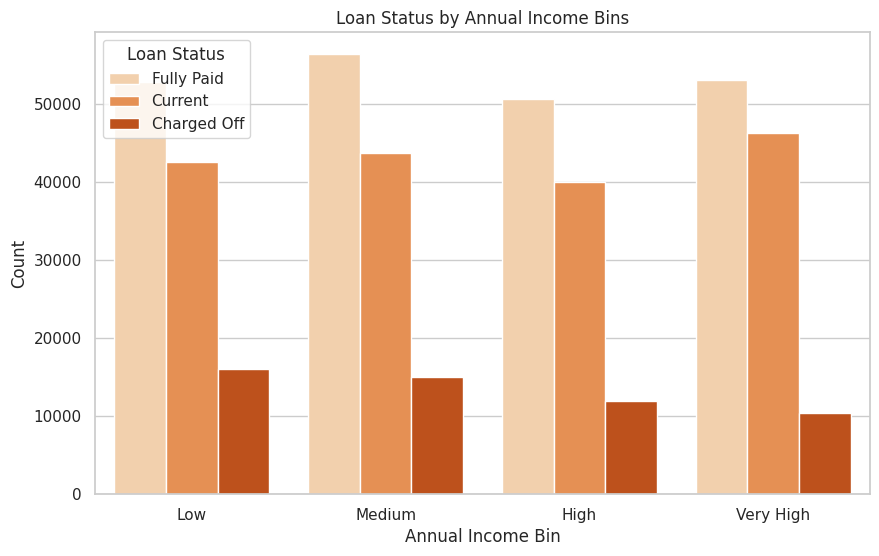

In [54]:
# Loan Status by Annual Income Bins
# Helps lenders and borrowers understand how income levels affect loan outcomes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

df_for_income_analysis = spark.read.option("header", "true").option("inferSchema", "false") \
    .csv("hdfs://localhost:9000/user/hduser/input/accepted_2007_to_2018Q4.csv") \
    .select('loan_status', 'annual_inc').na.drop()

df_for_income_analysis = df_for_income_analysis.withColumn("annual_inc", col("annual_inc").cast("float"))

df_filtered = df_for_income_analysis.filter(
    (col('loan_status').isin(['Fully Paid', 'Charged Off', 'Current'])) &
    (col('annual_inc') > 1000) & (col('annual_inc') < 250000) 
)

df_pandas = df_filtered.sample(False, 0.2, seed=42).toPandas()

df_pandas['income_bin'] = pd.qcut(df_pandas['annual_inc'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize=(10, 6))
sns.countplot(x='income_bin', hue='loan_status', data=df_pandas, palette='Oranges')
plt.title('Loan Status by Annual Income Bins')
plt.xlabel('Annual Income Bin')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

# DATA PREPROCESSING

In [15]:
df_with_count = df.groupBy('purpose').count()
df_with_count.show()

[Stage 12:===================================================>    (12 + 1) / 13]

+------------------+-------+
|           purpose|  count|
+------------------+-------+
|           wedding|   2351|
|             other| 139270|
|    small_business|  24638|
|debt_consolidation|1276774|
|       credit_card| 516570|
|            moving|  15369|
|          vacation|  15518|
|  renewable_energy|   1444|
|             house|  14119|
|               car|  23996|
|    major_purchase|  50400|
|           medical|  27453|
|  home_improvement| 150290|
|       educational|    404|
+------------------+-------+



In [16]:
df.groupby('term').count().show()

[Stage 15:===================================================>    (12 + 1) / 13]

+----------+-------+
|      term|  count|
+----------+-------+
| 36 months|1608405|
| 60 months| 650191|
+----------+-------+



In [17]:
df = df.withColumn("term", regexp_extract(col("term"), r'(\d+)', 0).cast("int"))
df.groupby('term').count().show()

[Stage 18:===================================================>    (12 + 1) / 13]

+----+-------+
|term|  count|
+----+-------+
|  60| 650191|
|  36|1608405|
+----+-------+



In [18]:
df.groupby('verification_status').count().show()

[Stage 21:===================================================>    (12 + 1) / 13]

+-------------------+------+
|verification_status| count|
+-------------------+------+
|           Verified|629395|
|    Source Verified|886141|
|       Not Verified|743060|
+-------------------+------+



In [19]:
# Encode 'verification_status' column values into a new column 'verification_status_encoded'
# If either "Verified" or "Source Verified", 0
# Otherwise, 1

df = df\
.withColumn("verification_status_encoded",
            when(col("verification_status")
                 .isin(["Verified", "Source Verified"]),0)
            .otherwise(1))\
.drop("verification_status")

In [20]:
df.groupby('verification_status_encoded').count().show()

[Stage 24:===================================================>    (12 + 1) / 13]

+---------------------------+-------+
|verification_status_encoded|  count|
+---------------------------+-------+
|                          1| 743060|
|                          0|1515536|
+---------------------------+-------+



In [21]:
df.groupby('acc_now_delinq').count().show()

[Stage 27:===================================================>    (12 + 1) / 13]

+--------------+-------+
|acc_now_delinq|  count|
+--------------+-------+
|           1.0|   8290|
|           0.0|2249817|
|           5.0|      3|
|           4.0|     11|
|           2.0|    421|
|           3.0|     50|
|          14.0|      1|
|           6.0|      2|
|           7.0|      1|
+--------------+-------+



In [22]:
valid_values = [0, 1, 2, 3, 4]

# Cast string -> float -> int (this handles '0.0' strings properly)
df = df.withColumn('acc_now_delinq', col('acc_now_delinq').cast('float').cast('int')) \
       .withColumn('acc_now_delinq', when(col('acc_now_delinq') >= 4, 4).otherwise(col('acc_now_delinq'))) \
       .filter(col('acc_now_delinq').isin(valid_values))

df.groupby('acc_now_delinq').count().show()

[Stage 30:===================================================>    (12 + 1) / 13]

+--------------+-------+
|acc_now_delinq|  count|
+--------------+-------+
|             1|   8290|
|             3|     50|
|             4|     18|
|             2|    421|
|             0|2249817|
+--------------+-------+



In [23]:
df.groupby('application_type').count().show()

[Stage 33:===================================================>    (12 + 1) / 13]

+----------------+-------+
|application_type|  count|
+----------------+-------+
|       Joint App| 118999|
|      Individual|2139597|
+----------------+-------+



In [24]:
# valid_values = ['Joint App', 'Individual']

# Modify the 'application_type' column:
# 1. Map 'Joint App' to 0 and 'Individual' to 1
# 2. Remove other values
# 3. Cast the column to IntegerType

df = df.withColumn('application_type',
                   when(col('application_type') == 'Joint App', 0)
                   .when(col('application_type') == 'Individual', 1)
                   .otherwise(None))

df = df.filter(col('application_type').isNotNull()).withColumn('application_type', col('application_type').cast('int'))

In [25]:
df.groupBy('application_type').count().show()

[Stage 36:===================================================>    (12 + 1) / 13]

+----------------+-------+
|application_type|  count|
+----------------+-------+
|               1|2139597|
|               0| 118999|
+----------------+-------+



In [26]:
df.groupby('grade').count().show()

[Stage 39:===================================================>    (12 + 1) / 13]

+-----+------+
|grade| count|
+-----+------+
|    F| 41758|
|    E|135506|
|    B|663013|
|    D|324042|
|    C|649471|
|    A|432662|
|    G| 12144|
+-----+------+



# PREPARING DATA FOR PREDICTIVE ANALYSIS

In [27]:
# label encoding

grade_indexer = StringIndexer(inputCol="grade", outputCol="grade_index", stringOrderType="alphabetAsc")

df = grade_indexer\
.fit(df)\
.transform(df)\
.drop('grade')

In [28]:
df.groupby('grade_index').count().show()

[Stage 45:===================================================>    (12 + 1) / 13]

+-----------+------+
|grade_index| count|
+-----------+------+
|        0.0|432662|
|        1.0|663013|
|        4.0|135506|
|        3.0|324042|
|        2.0|649471|
|        6.0| 12144|
|        5.0| 41758|
+-----------+------+



In [29]:
# one-hot encoding
columns_to_encode = ['purpose', 'addr_state', 'home_ownership', 'initial_list_status']

for column in columns_to_encode:
    df = one_hot_encode_column(df, column)

In [30]:
columns_to_cast = [ 'installment',
                   'int_rate',
                    'loan_amnt',
                    'annual_inc',
                    'dti',
                    'tax_liens',
                    'delinq_amnt',
                    'policy_code',
                    'last_fico_range_high',
                    'last_fico_range_low',
                    'recoveries',
                    'collection_recovery_fee'
]

# cast to float
for column_name in columns_to_cast:
    df = df.withColumn(column_name, col(column_name).cast('float'))

In [31]:
df.dtypes

[('id', 'string'),
 ('term', 'int'),
 ('acc_now_delinq', 'int'),
 ('annual_inc', 'float'),
 ('application_type', 'int'),
 ('dti', 'float'),
 ('installment', 'float'),
 ('int_rate', 'float'),
 ('loan_amnt', 'float'),
 ('loan_status', 'string'),
 ('tax_liens', 'float'),
 ('delinq_amnt', 'float'),
 ('policy_code', 'float'),
 ('last_fico_range_high', 'float'),
 ('last_fico_range_low', 'float'),
 ('recoveries', 'float'),
 ('collection_recovery_fee', 'float'),
 ('verification_status_encoded', 'int'),
 ('grade_index', 'double'),
 ('purpose_encoded', 'vector'),
 ('addr_state_encoded', 'vector'),
 ('home_ownership_encoded', 'vector'),
 ('initial_list_status_encoded', 'vector')]

In [32]:
df.groupby('loan_status').count()\
.show()

[Stage 72:===================================================>    (12 + 1) / 13]

+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1076218|
|             Default|     40|
|     In Grace Period|   8427|
|         Charged Off| 268452|
|  Late (31-120 days)|  21443|
|             Current| 877018|
|   Late (16-30 days)|   4344|
|Does not meet the...|   1913|
|Does not meet the...|    741|
+--------------------+-------+



In [33]:
# encode 'loan_status' to 0 - fully paid, 1 - late, 2 - charged off
df = df.withColumn("target",
                   when(col("loan_status") == "Fully Paid", 0)
                   .when((col("loan_status") == "Late (16-30 days)") | (col("loan_status") == "Late (31-120 days)") | (col("loan_status") == "In Grace Period"), 1)
                   .when((col("loan_status") == "Charged Off") | (col("loan_status") == 'Default'), 2)
                   .otherwise(None))\
.drop("loan_status")
df = df.filter(df.target.isNotNull())

In [34]:
df.groupby('target').count()\
.show()

[Stage 75:===================================================>    (12 + 1) / 13]

+------+-------+
|target|  count|
+------+-------+
|     1|  34214|
|     2| 268492|
|     0|1076218|
+------+-------+



In [35]:
df = df.drop('id')
df_downsampled = df.filter(col("target") == 0).sampleBy("target", fractions={0: 0.3}).unionAll(df.filter(col("target") != 0))
df_downsampled = df_downsampled.na.drop()

# DOWNSAMPLING

In [55]:
df_downsampled.groupby('target').count()\
.show()

[Stage 114:==================================================>    (24 + 2) / 26]

+------+------+
|target| count|
+------+------+
|     0|322534|
|     1| 34214|
|     2|268492|
+------+------+



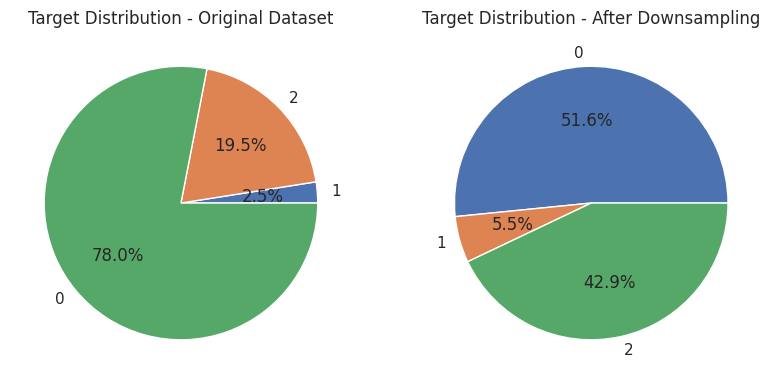

In [56]:
loan_status_count_original = df.groupby('target').count().toPandas()

plt.figure(figsize=(15, 6))

# Subplot 1 - Target Distribution before downsampling
plt.subplot(1, 3, 1)
plt.pie(loan_status_count_original['count'], labels=loan_status_count_original['target'], autopct='%1.1f%%')
plt.title('Target Distribution - Original Dataset')

# Downsampled dataset
loan_status_count_downsampled = df_downsampled.groupby('target').count().toPandas()

# Subplot 2 - Target Distribution after downsampling
plt.subplot(1, 3, 2)
plt.pie(loan_status_count_downsampled['count'], labels=loan_status_count_downsampled['target'], autopct='%1.1f%%')
plt.title('Target Distribution - After Downsampling')

plt.show()

In [57]:
all_columns = df_downsampled.columns
feature_cols = [col_name for col_name in all_columns if col_name != 'target']

target = ['target']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_to_scale")

df_downsampled = assembler.transform(df_downsampled)

df_downsampled\
.select('features_to_scale', 'target')\
.show(5)

+--------------------+------+
|   features_to_scale|target|
+--------------------+------+
|(86,[0,2,4,5,6,7,...|     0|
|(86,[0,2,3,4,5,6,...|     0|
|(86,[0,2,3,4,5,6,...|     0|
|(86,[0,2,3,4,5,6,...|     0|
|(86,[0,2,3,4,5,6,...|     0|
+--------------------+------+
only showing top 5 rows


# DEFAULT PREDICTION

In [58]:
train_data, temp_data = df_downsampled.randomSplit([0.8, 0.2], seed=42)
test_data, val_data = temp_data.randomSplit([0.5, 0.5], seed=42)

In [59]:
train_data = scale_features(train_data, "features_to_scale", "features")
val_data = scale_features(val_data, "features_to_scale", "features")
test_data = scale_features(test_data, "features_to_scale", "features")

In [60]:
lr = LogisticRegression(featuresCol='features', labelCol='target')
results_df_lr = evaluate_model(lr, 'LogisticRegression', train_data, val_data, test_data)

25/10/10 19:47:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
                                                                                

In [61]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')
results_df_rf = evaluate_model(rf, 'Random Forest', train_data, val_data, test_data)

In [62]:
finalresults_default_pred = pd.concat([results_df_lr, results_df_rf], ignore_index=True)
finalresults_default_pred

Model  Accuracy (Train)  F1 Score (Train)  \
0  LogisticRegression             0.881             0.862   
1       Random Forest             0.880             0.856   

   Accuracy (Validation)  F1 Score (Validation)  Accuracy (Test)  \
0                  0.881                  0.862            0.883   
1                  0.880                  0.855            0.883   

   F1 Score (Test)  
0            0.864  
1            0.858

# LOAN AMT RECOMMENDATION

In [63]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [64]:
# Step 1: Prepare data for regression ('loan_amnt', set it as target)
# feature_cols_no_loan = [col_name for col_name in feature_cols if col_name != 'loan_amnt']
feature_cols_no_loan = [
    'annual_inc', 'dti', 'int_rate', 'grade_index',
    'verification_status_encoded', 'application_type',
    'last_fico_range_low', 'last_fico_range_high'
]
assembler_reg = VectorAssembler(inputCols=feature_cols_no_loan, outputCol="features_to_scale_reg")

df_downsampled_reg = assembler_reg.transform(df_downsampled).select("features_to_scale_reg", "loan_amnt")

In [65]:
# Step 2: Split data (reuse the same splits for consistency)
train_data_reg, temp_data_reg = df_downsampled_reg.randomSplit([0.8, 0.2], seed=42)
test_data_reg, val_data_reg = temp_data_reg.randomSplit([0.5, 0.5], seed=42)

# Step 3: Scale features for regression
train_data_reg = scale_features(train_data_reg, "features_to_scale_reg", "features")
val_data_reg = scale_features(val_data_reg, "features_to_scale_reg", "features")
test_data_reg = scale_features(test_data_reg, "features_to_scale_reg", "features")


In [66]:
# Step 4: Define evaluation function for regression
def evaluate_regression_model(model, model_name, train_data, validation_data, test_data):
    model = model.fit(train_data)
    
    predictions_train = model.transform(train_data)
    predictions_validation = model.transform(validation_data)
    predictions_test = model.transform(test_data)
    
    evaluator_rmse = RegressionEvaluator(labelCol="loan_amnt", predictionCol="prediction", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol="loan_amnt", predictionCol="prediction", metricName="r2")
    
    rmse_train = evaluator_rmse.evaluate(predictions_train)
    r2_train = evaluator_r2.evaluate(predictions_train)
    
    rmse_validation = evaluator_rmse.evaluate(predictions_validation)
    r2_validation = evaluator_r2.evaluate(predictions_validation)
    
    rmse_test = evaluator_rmse.evaluate(predictions_test)
    r2_test = evaluator_r2.evaluate(predictions_test)
    
    results_df = pd.DataFrame({
        "Model": [model_name],
        "RMSE (Train)": [round(rmse_train, 3)],
        "R² (Train)": [round(r2_train, 3)],
        "RMSE (Validation)": [round(rmse_validation, 3)],
        "R² (Validation)": [round(r2_validation, 3)],
        "RMSE (Test)": [round(rmse_test, 3)],
        "R² (Test)": [round(r2_test, 3)],
    })
    
    return results_df


In [67]:
# Step 5: Train Linear Regression
lr_reg = LinearRegression(featuresCol='features', labelCol='loan_amnt')
results_df_lr_reg = evaluate_regression_model(lr_reg, 'Linear Regression (Loan Amt Reco)', train_data_reg, val_data_reg, test_data_reg)

# Step 6: Train Random Forest Regressor
rf_reg = RandomForestRegressor(featuresCol='features', labelCol='loan_amnt', numTrees=20, seed=42)
results_df_rf_reg = evaluate_regression_model(rf_reg, 'Random Forest Regressor (Loan Amt Reco)', train_data_reg, val_data_reg, test_data_reg)


25/10/10 19:56:22 WARN Instrumentation: [32476ef6] regParam is zero, which might cause numerical instability and overfitting.
25/10/10 19:56:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
                                                                                

In [68]:
# Step 7: Combine and display results
final_results_loan_reco = pd.concat([results_df_lr_reg, results_df_rf_reg], ignore_index=True)
final_results_loan_reco

Model  RMSE (Train)  R² (Train)  \
0        Linear Regression (Loan Amt Reco)      8053.432       0.169   
1  Random Forest Regressor (Loan Amt Reco)      7311.866       0.315   

   RMSE (Validation)  R² (Validation)  RMSE (Test)  R² (Test)  
0           8132.493            0.155     8055.530      0.173  
1           7713.697            0.240     7553.112      0.273

# SPARK SQL FOR QUERYING

In [69]:
# Register the processed df (before downsampling) as a temporary view for Spark SQL queries
df.createOrReplaceTempView("loan_df")

In [70]:
# Query 1: Distribution of loan statuses (target) across the dataset
# Justification: Provides a quick overview of class imbalance in loan outcomes, essential for understanding default risk prevalence and model training challenges.
query1 = """
SELECT target, COUNT(*) as count, ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
FROM loan_df
GROUP BY target
ORDER BY count DESC
"""
result1 = spark.sql(query1)
result1.show()

25/10/10 20:00:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 20:00:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 20:00:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
[Stage 435:==================================================>    (12 + 1) / 13]

+------+-------+----------+
|target|  count|percentage|
+------+-------+----------+
|     0|1076218|     78.05|
|     2| 268492|     19.47|
|     1|  34214|      2.48|
+------+-------+----------+



25/10/10 20:01:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 20:01:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 20:01:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 20:01:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

In [71]:
# Query 2: Average annual income and loan amount by credit grade
# Justification: Highlights how borrower income and requested loan amounts correlate with credit grade.
query2 = """
SELECT grade_index, 
       ROUND(AVG(annual_inc), 2) as avg_annual_inc, 
       ROUND(AVG(loan_amnt), 2) as avg_loan_amnt
FROM loan_df
GROUP BY grade_index
ORDER BY grade_index
"""
result2 = spark.sql(query2)
result2.show()

[Stage 441:==================================================>    (12 + 1) / 13]

+-----------+--------------+-------------+
|grade_index|avg_annual_inc|avg_loan_amnt|
+-----------+--------------+-------------+
|        0.0|      89042.07|     13916.85|
|        1.0|      76605.14|     13290.93|
|        2.0|       72862.1|     14276.68|
|        3.0|      70303.14|     15351.91|
|        4.0|      72105.19|     17643.26|
|        5.0|      73148.52|     19137.98|
|        6.0|      76213.32|     20625.52|
+-----------+--------------+-------------+



In [72]:
# Query 3: Top 5 credit grades by average DTI for high-risk loans (target=2, charged off/default)
# Justification: Identifies credit grades with highest debt burden in default cases, informing strategic planning to mitigate risks in specific borrower segments.
query3 = """
SELECT grade_index, 
       ROUND(AVG(dti), 2) as avg_dti
FROM loan_df
WHERE target = 2
GROUP BY grade_index
ORDER BY avg_dti DESC
LIMIT 5
"""
result3 = spark.sql(query3)
result3.show()

[Stage 444:==================================================>    (12 + 1) / 13]

+-----------+-------+
|grade_index|avg_dti|
+-----------+-------+
|        6.0|   22.3|
|        5.0|  22.06|
|        4.0|  21.88|
|        3.0|  21.17|
|        2.0|  19.92|
+-----------+-------+



In [73]:
# Query 4 : Count and average interest rate by credit grade and verification status, filtered for loans > $10k
# Justification: Reveals patterns in interest rates and application volumes by credit grade and verification, supporting compliance checks and optimized offers for verified borrowers.
query4 = """
SELECT grade_index, verification_status_encoded,
       COUNT(*) as loan_count,
       ROUND(AVG(int_rate), 2) as avg_int_rate
FROM loan_df
WHERE loan_amnt > 10000
GROUP BY grade_index, verification_status_encoded
HAVING loan_count > 100
ORDER BY avg_int_rate DESC
"""
result4 = spark.sql(query4)
result4.show()

[Stage 447:==================================================>    (12 + 1) / 13]

+-----------+---------------------------+----------+------------+
|grade_index|verification_status_encoded|loan_count|avg_int_rate|
+-----------+---------------------------+----------+------------+
|        6.0|                          1|       505|       28.68|
|        6.0|                          0|      8009|       27.76|
|        5.0|                          1|      1989|        25.9|
|        5.0|                          0|     25390|       25.01|
|        4.0|                          1|      8007|       21.65|
|        4.0|                          0|     65021|       21.15|
|        3.0|                          0|    109542|        17.8|
|        3.0|                          1|     22833|       17.77|
|        2.0|                          0|    174416|       14.17|
|        2.0|                          1|     52845|        13.9|
|        1.0|                          0|    144530|       10.76|
|        1.0|                          1|     66054|       10.48|
|        0